In [1]:
import numpy as np

from scipy.io.wavfile import read
from scipy.fft import fft, fftfreq, fftshift
from scipy.signal import freqz
import IPython.display as ipd

import matplotlib.pyplot as plt

In [2]:
sr, audio = read('../H1/string_1.wav')

## FIR delay

### 1. Impulse response

Under the framework of FIR filters, given by the following equation:

$$
y[t] = \sum_{n=0}^{K-1} h[n]x[t-n]
$$

the filter $s[t] = e[t] + \alpha e[t-D]$, corresponds to an impulse of size $K=D+1$ with values

$$
h[n] = \begin{cases} 
1 & \text{if } n = 0, \\
\alpha & \text{if } n = D, \\
0 & \text{otherwise.}
\end{cases}
$$

In [4]:
DELAY = 10 # frames
ALPHA = 0.5

In [5]:
def delay_filter_fir(audio, delay=DELAY, alpha=ALPHA):
    # We add zeros to the beginning of the delayed audio
    new_audio = audio + alpha*np.concatenate([np.zeros(delay), audio[:-delay]])
    return new_audio

In [6]:
delay = delay_filter_fir(audio)

Text(0.5, 0, 'Time (s)')

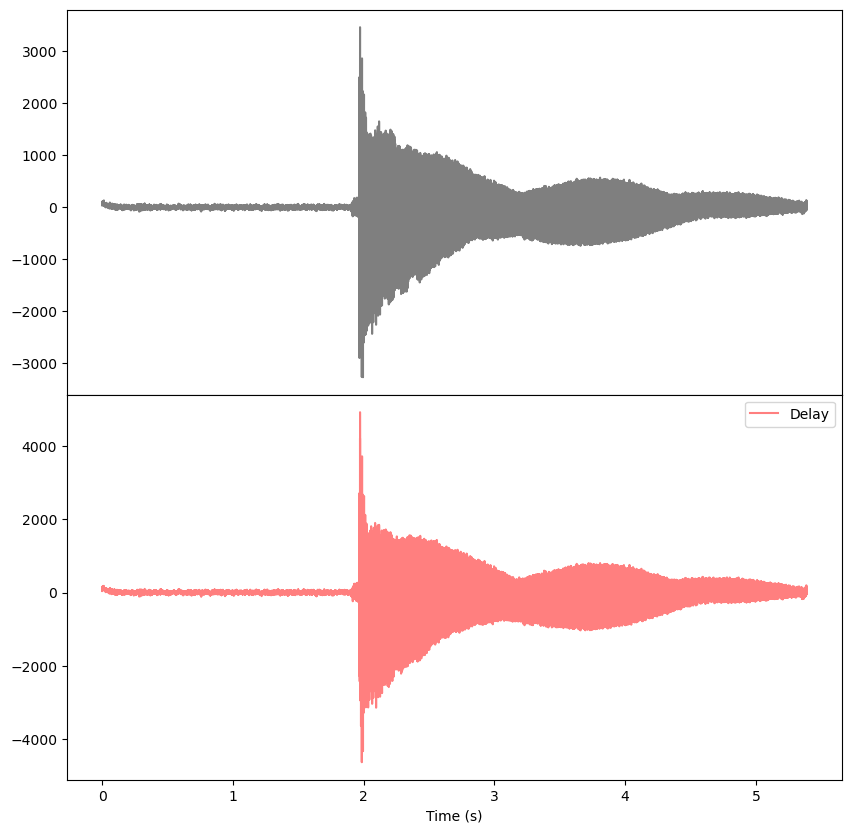

In [7]:
# Plotting
t = np.linspace(0, len(audio)/sr, len(audio))

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10), sharex=True, gridspec_kw={'hspace': 0})

ax1.plot(t, audio, label='Original', alpha=0.5, c='black')
ax2.plot(t, delay, label='Delay', alpha=0.5, c='red')
plt.legend()

plt.xlabel('Time (s)')

## Frequency domain interpretation

In [8]:
def fourier_transform(signal):
    N = len(signal)
    T = 1.0 / sr
    yf = fft(signal)
    xf = fftshift(fftfreq(N, T))
    return xf, fftshift(yf)

In [9]:
xf, og_transform = fourier_transform(audio)
xf, delay_transform = fourier_transform(delay)

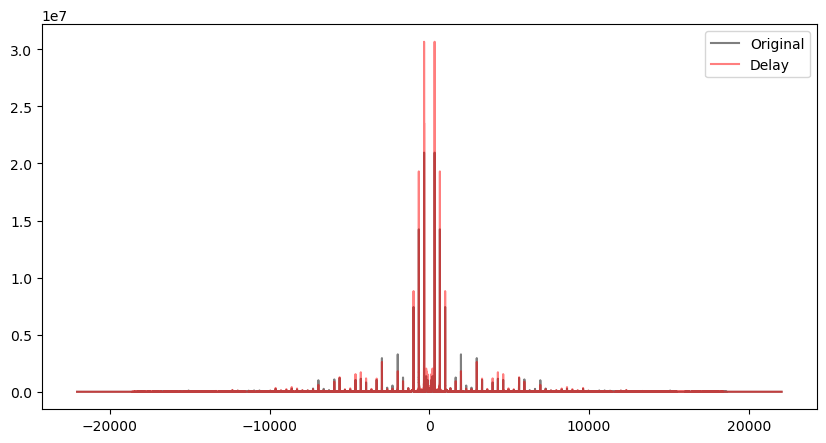

In [10]:
# Plotting

# fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10), sharex=True, gridspec_kw={'hspace': 0})
plt.figure(figsize=(10, 5))
plt.plot(xf, np.abs(og_transform), label='Original', alpha=0.5, c='black')
plt.plot(xf, np.abs(delay_transform), label='Delay', alpha=0.5, c='red')
plt.legend()

In [11]:
# Constructing the filter array
filter = np.zeros(DELAY+1)
filter[0] = 1
filter[-1] = ALPHA

In [12]:
filter_freq, filter_trans = freqz(filter, worN=len(audio), fs=sr)

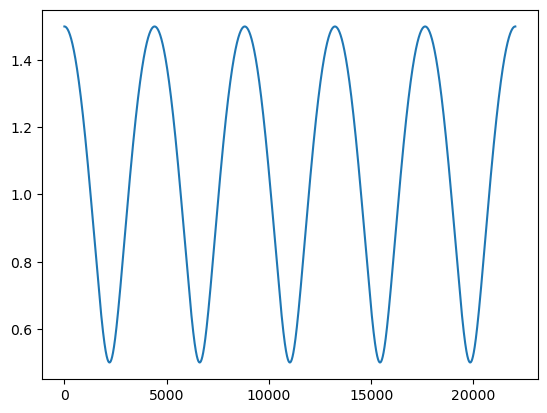

In [14]:
plt.plot(filter_freq, np.abs(filter_trans))

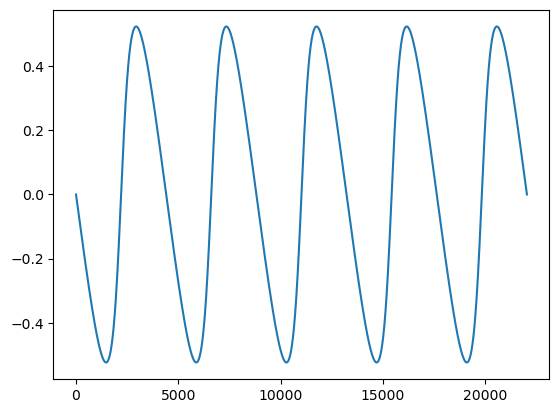

In [15]:
plt.plot(filter_freq, np.angle(filter_trans))

## IIR delay

### 1. Impulse response with D=1

The general framework of IIR filters is given by the equation:

$$
y[t] = \sum_{n=0}^{M} b[n] x[t-n] - \sum_{n=1}^{N} a[n] y[t-n]
$$

To formulate our filter in these terms we can take $M=0$ and $N=1$. This means that $b[0] = \alpha$ and $a[0]=0$, $a[1]=-\beta$ so we can recover the equation 
$$s[t] = \alpha e[t] + \beta s[t-1]$$

### 2. Frequency response of the filter

In [26]:
ALPHA = 0.5
BETA = 0.3

In [27]:
a = np.array([0]*DELAY+[-BETA])
b = np.array([ALPHA])

filter_freq, filter_trans = freqz(b, a=a, worN=len(audio), fs=sr)

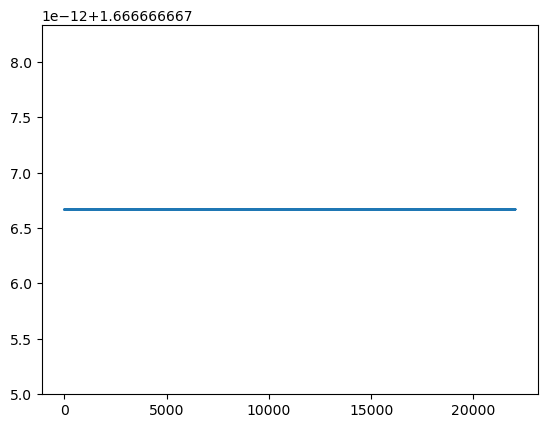

In [28]:
plt.plot(filter_freq, np.abs(filter_trans))

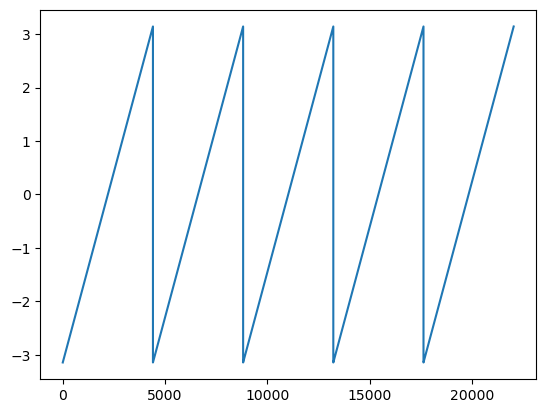

In [29]:
plt.plot(filter_freq, np.angle(filter_trans))

### 3. Implementing the filter

In [20]:
def delay_filter_iir(audio, delay=DELAY, alpha=ALPHA, beta=BETA):
    new_audio = np.zeros(len(audio))
    new_audio[:delay] = alpha*audio[:delay]
    for i in range(delay, len(audio)):
        new_audio[i] = alpha*audio[i] + beta*new_audio[i-delay]
    
    return new_audio

In [21]:
delay = delay_filter_iir(audio)

Text(0.5, 0, 'Time (s)')

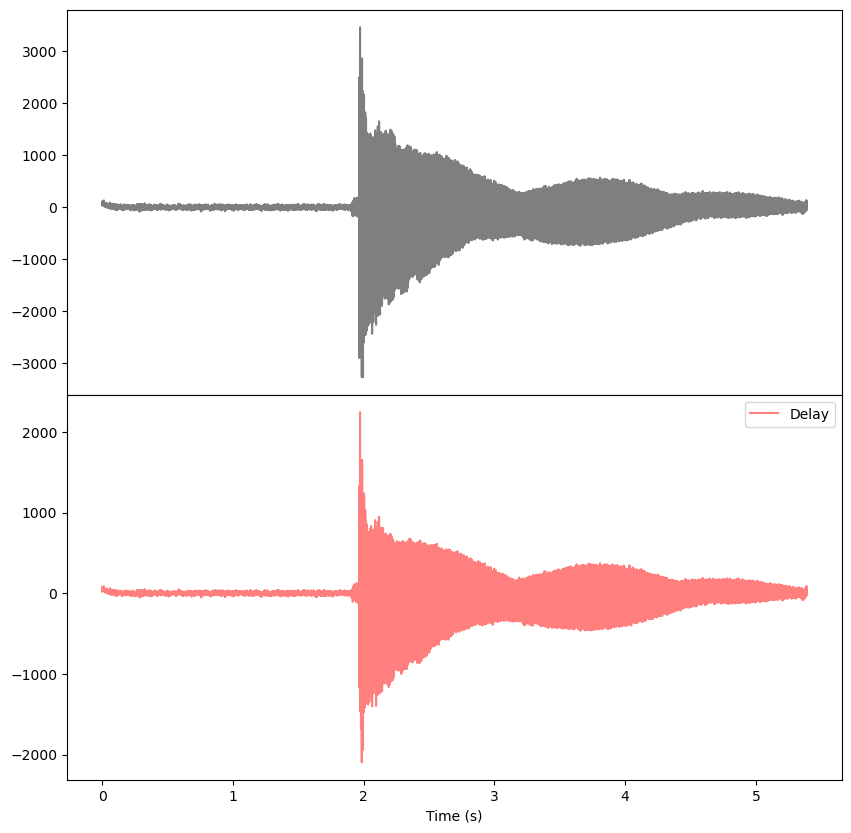

In [22]:
# Plotting
t = np.linspace(0, len(audio)/sr, len(audio))

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10), sharex=True, gridspec_kw={'hspace': 0})

ax1.plot(t, audio, label='Original', alpha=0.5, c='black')
ax2.plot(t, delay, label='Delay', alpha=0.5, c='red')
plt.legend()

plt.xlabel('Time (s)')

In [23]:
xf, og_transform = fourier_transform(audio)
xf, delay_transform = fourier_transform(delay)

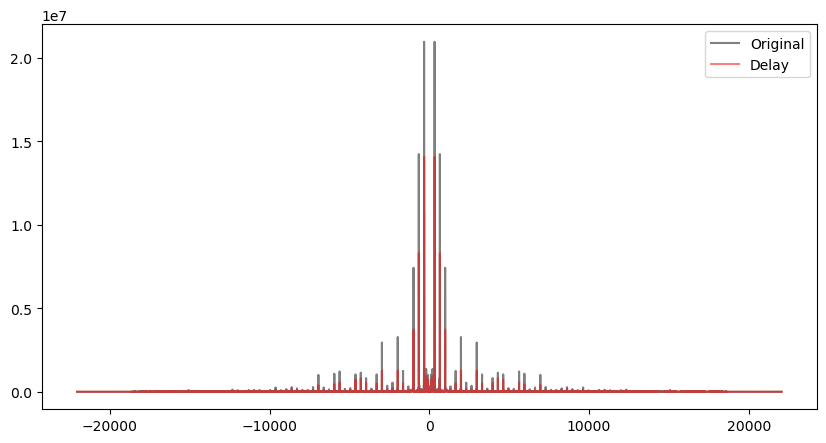

In [24]:
# Plotting
plt.figure(figsize=(10, 5))
plt.plot(xf, np.abs(og_transform), label='Original', alpha=0.5, c='black')
plt.plot(xf, np.abs(delay_transform), label='Delay', alpha=0.5, c='red')
plt.legend()

### 4. Stability?

The implementation is not always stable because there could be cases where the output signal grows exponentially and diverges. One such case is when $\beta\gt 1$ and there's a positive input signal.

Doing a bit of math we found a direct relationship between the output and the input of the filter, given by:

$$
s[n] = \alpha\sum_{d=0}^{n} \beta^{d} e[n-d].
$$

This can diverge very quickly for a large n and $\beta\gt1$.

### 5.  Parameters?

The $\alpha$ term in the equation controls how much of the current value of the signal adds to the output, whereas $\beta$ gives you the contribution of the previous value of the output to the current one. Higher values of $\alpha$ in comparison to $\beta$ give signals that behave more similarly with the original signal, whereas a higher $\beta$ corresponds to a filter that tends to echo the input many times without incorporating new information.  

### 6. Comparison

The IIR filter has the problem that it cannot be vectorized in Python, so it requires a for loop which will be much slower than the vectorized implementation of the FIR. To see how much slower we used the ```%%timeit``` magic function of Jupyter so to get an estimate of the time it takes to each filter to run. Based on the results on our devices, we can say that the IIR filter is 3 orders of magnitude slower that the FIR one. 

In [23]:
%%timeit 

delay_filter_fir(audio)

241 µs ± 5.17 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [24]:
%%timeit 

delay_filter_iir(audio)

292 ms ± 10.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
